<a href="https://colab.research.google.com/github/ayeshatofa/Email-Classification-using-RNN/blob/main/CODE_2257_1002_1026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unidecode tensorflow scikit-learn pandas numpy matplotlib seaborn nltk

In [ ]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from collections import Counter
import nltk
from nltk import ngrams
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Loading Dataset**

In [ ]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/ayeshatofa/Email-Classification-using-RNN/main/Emailscam.csv",
    encoding="latin1"
)

**Spliting Dataset**

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['class'])

# First split: Train + Temp
df_train, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label_encoded'],
    random_state=42
)

# Second split: Validation + Test
df_val, df_test = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label_encoded'],
    random_state=42
)

# Extract features and labels
X_train = df_train['message']
y_train = df_train['label_encoded']

X_val = df_val['message']
y_val = df_val['label_encoded']

X_test = df_test['message']
y_test = df_test['label_encoded']


**Examples of Train Dataset**

In [ ]:
ham=df_train[df_train['class']=='ham']['message']
spam=df_train[df_train['class']=='spam']['message']
print("First 10 samples of ham\n".format(),ham[:10])
print("First 10 samples of  spam\n".format(),spam[:10])
df_train

First 10 samples of ham
 184                            Going on nothing great.bye
2171                        I wont. So wat's wit the guys
5422              Ok k..sry i knw 2 siva..tats y i askd..
4113    Where are you ? What do you do ? How can you s...
4588         Have you not finished work yet or something?
1581    Hhahhaahahah rofl wtf nig was leonardo in your...
3971                                        WOT U UP 2 J?
2701    Hiya, sorry didn't hav signal. I haven't seen ...
2755                                We r outside already.
1754    How is your schedule next week? I am out of to...
Name: message, dtype: object
First 10 samples of  spam
 1847    FREE NOKIA Or Motorola with upto 12mths 1/2pri...
2052    Call 09094100151 to use ur mins! Calls cast 10...
4154    Want a new Video Phone? 750 anytime any networ...
3911    You have an important customer service announc...
597     You have an important customer service announc...
1572    Ur cash-balance is currently 500 pounds -

,class,message,label_encoded
184,ham,Going on nothing great.bye,0
2171,ham,I wont. So wat's wit the guys,0
5422,ham,Ok k..sry i knw 2 siva..tats y i askd..,0
4113,ham,Where are you ? What do you do ? How can you s...,0
4588,ham,Have you not finished work yet or something?,0
...,...,...,...
1932,ham,Jus finished avatar nigro,0
5316,ham,Jus finish watching tv... U?,0
2308,spam,Moby Pub Quiz.Win a å£100 High Street prize if...,1
1903,spam,Free entry in 2 a weekly comp for a chance to ...,1


**EDA**

Total counts of both message types:
 class
ham     3859
spam     598
Name: count, dtype: int64


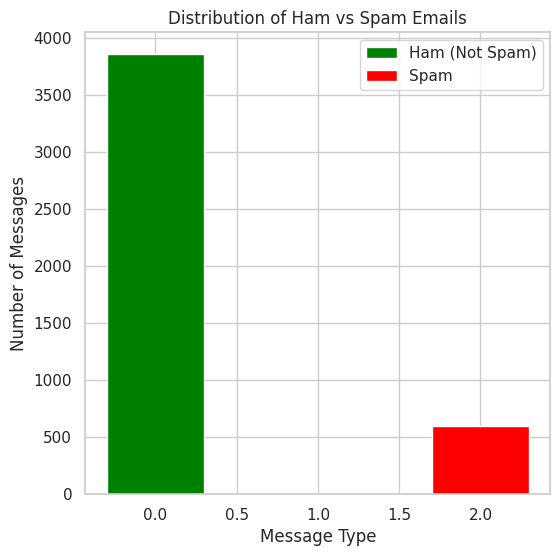

In [ ]:
# Count of ham and spam messages
count = df_train['class'].value_counts()
print('Total counts of both message types:\n', count)
print("==============")

# Function to plot counts using matplotlib
def plot_counts(count_ham, count_spam):
    plt.rcParams['figure.figsize'] = (6, 6)
    plt.bar(0, count_ham, width=0.6, label='Ham (Not Spam)', color='green')
    plt.bar(2, count_spam, width=0.6, label='Spam', color='red')
    plt.legend()
    plt.ylabel('Number of Messages')
    plt.xlabel('Message Type')
    plt.title('Distribution of Ham vs Spam Emails')
    plt.show()

# Call the function
plot_counts(count['ham'], count['spam'])


Train set counts:
 class
ham     3859
spam     598
Name: count, dtype: int64

Validation set counts:
 class
ham     483
spam     74
Name: count, dtype: int64

Test set counts:
 class
ham     483
spam     75
Name: count, dtype: int64


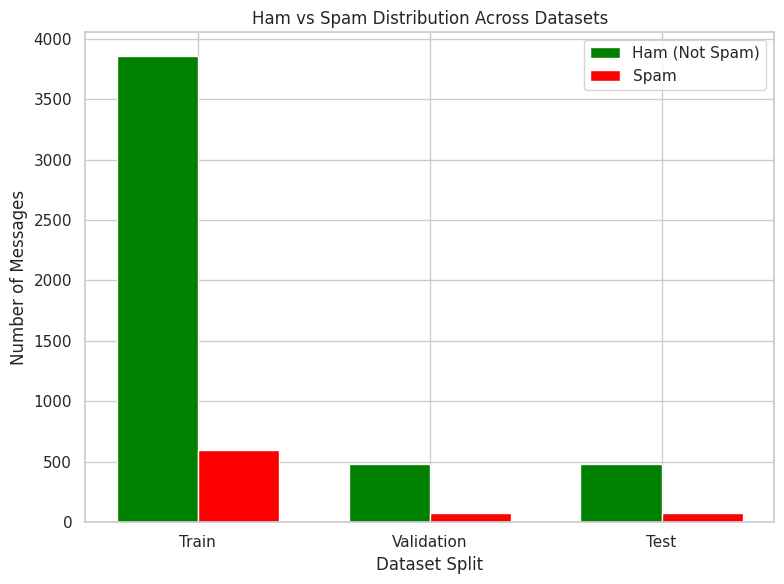

In [ ]:
# 📊 Count of ham and spam messages in all splits
train_count = df_train['class'].value_counts()
val_count   = df_val['class'].value_counts()
test_count  = df_test['class'].value_counts()

print("Train set counts:\n", train_count)
print("\nValidation set counts:\n", val_count)
print("\nTest set counts:\n", test_count)
print("==============")

# 📈 Function to plot counts for all three sets
def plot_counts(train_ham, train_spam, val_ham, val_spam, test_ham, test_spam):
    plt.figure(figsize=(8,6))

    # X positions
    x = np.arange(3)
    width = 0.35

    # Bars for ham and spam
    plt.bar(x - width/2, [train_ham, val_ham, test_ham], width, label='Ham (Not Spam)', color='green')
    plt.bar(x + width/2, [train_spam, val_spam, test_spam], width, label='Spam', color='red')

    # Labels & title
    plt.xticks(x, ['Train', 'Validation', 'Test'])
    plt.ylabel('Number of Messages')
    plt.xlabel('Dataset Split')
    plt.title('Ham vs Spam Distribution Across Datasets')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🧮 Call the function
plot_counts(
    train_count.get('ham', 0), train_count.get('spam', 0),
    val_count.get('ham', 0), val_count.get('spam', 0),
    test_count.get('ham', 0), test_count.get('spam', 0)
)


⚠️ 'clean_text' added for Train
⚠️ 'clean_text' added for Validation
⚠️ 'clean_text' added for Test

📊 Analysing Train dataset...
Train Ham Summary:
 count    3859.000000
mean       14.140192
std        11.378670
min         1.000000
25%         7.000000
50%        11.000000
75%        18.000000
max       171.000000
Name: clean_text, dtype: float64
Train Spam Summary:
 count    598.000000
mean      23.913043
std        5.812174
min        2.000000
25%       22.000000
50%       25.000000
75%       28.000000
max       35.000000
Name: clean_text, dtype: float64


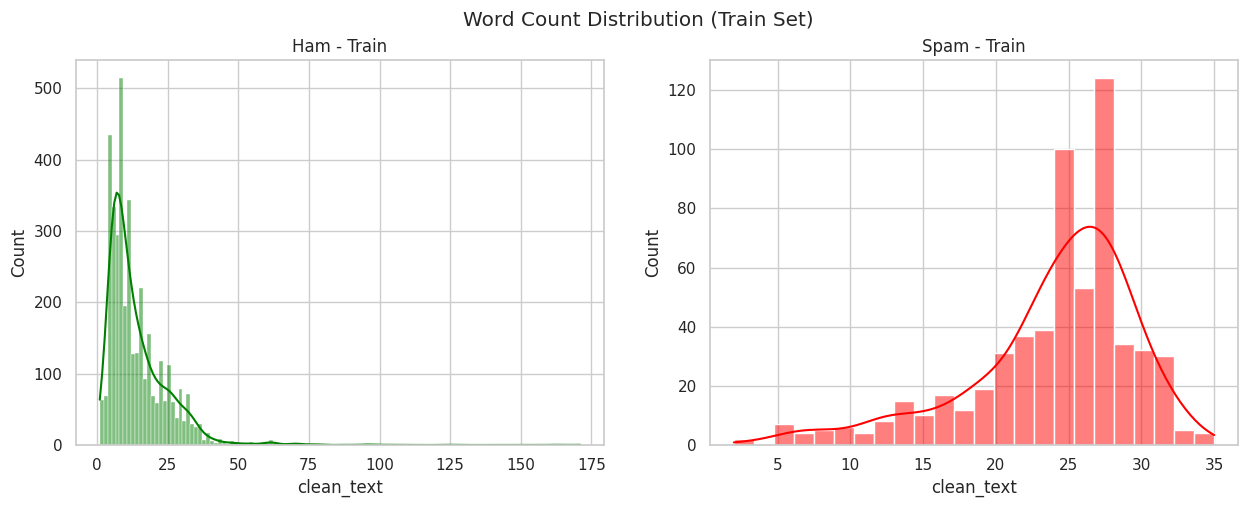


📊 Analysing Validation dataset...
Validation Ham Summary:
 count    483.000000
mean      14.844720
std       12.113686
min        1.000000
25%        7.000000
50%       11.000000
75%       20.000000
max      125.000000
Name: clean_text, dtype: float64
Validation Spam Summary:
 count    74.000000
mean     23.783784
std       5.447810
min       8.000000
25%      22.000000
50%      25.000000
75%      27.000000
max      31.000000
Name: clean_text, dtype: float64


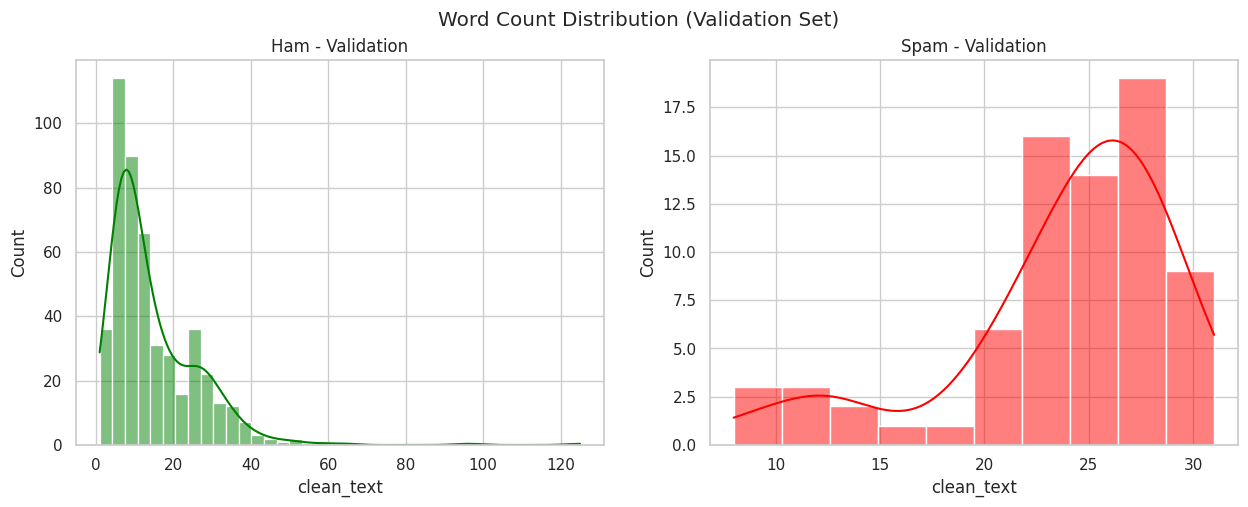


📊 Analysing Test dataset...
Test Ham Summary:
 count    483.000000
mean      14.039337
std       11.078581
min        1.000000
25%        7.000000
50%       10.000000
75%       18.000000
max       88.000000
Name: clean_text, dtype: float64
Test Spam Summary:
 count    75.000000
mean     23.426667
std       6.204125
min       2.000000
25%      21.500000
50%      24.000000
75%      27.500000
max      35.000000
Name: clean_text, dtype: float64


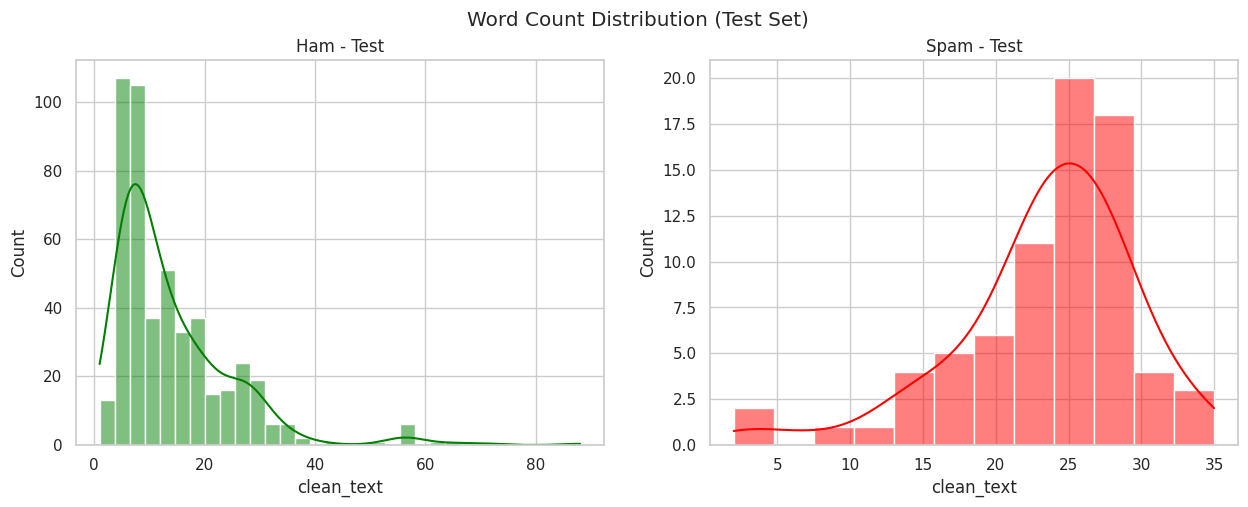

In [ ]:
# 1️⃣ Ensure all datasets have clean_text
for name, df in zip(['Train', 'Validation', 'Test'], [df_train, df_val, df_test]):
    if 'clean_text' not in df.columns:
        df['clean_text'] = df['message']
        print(f"⚠️ 'clean_text' added for {name}")
    else:
        print(f"✅ 'clean_text' found for {name}")

# 2️⃣ Define helper functions
def cal_len(words):
    if isinstance(words, list):
        return len(words)
    elif isinstance(words, str):
        return len(words.split())
    return 0

def plot_count(spam_counts, ham_counts, title_spam, title_ham, subtitle):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(ham_counts, ax=ax1, color='green', kde=True)
    ax1.set_title(title_ham)
    sns.histplot(spam_counts, ax=ax2, color='red', kde=True)
    ax2.set_title(title_spam)
    fig.suptitle(subtitle)
    plt.show()

# 3️⃣ Analyze each dataset
for name, df in zip(['Train', 'Validation', 'Test'], [df_train, df_val, df_test]):
    print(f"\n📊 Analysing {name} dataset...")
    ham_words = df[df['class'] == 'ham']['clean_text'].dropna().str.split().apply(cal_len)
    spam_words = df[df['class'] == 'spam']['clean_text'].dropna().str.split().apply(cal_len)
    print(f"{name} Ham Summary:\n", ham_words.describe())
    print(f"{name} Spam Summary:\n", spam_words.describe())
    plot_count(spam_words, ham_words,
               f"Spam - {name}", f"Ham - {name}",
               f"Word Count Distribution ({name} Set)")


Ham Message Punctuation Summary:
 count    3859.000000
mean        3.983156
std         4.813255
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       133.000000
Name: message, dtype: float64 

Spam Message Punctuation Summary:
 count    598.000000
mean       5.816054
std        3.480447
min        0.000000
25%        3.000000
50%        6.000000
75%        8.000000
max       26.000000
Name: message, dtype: float64 



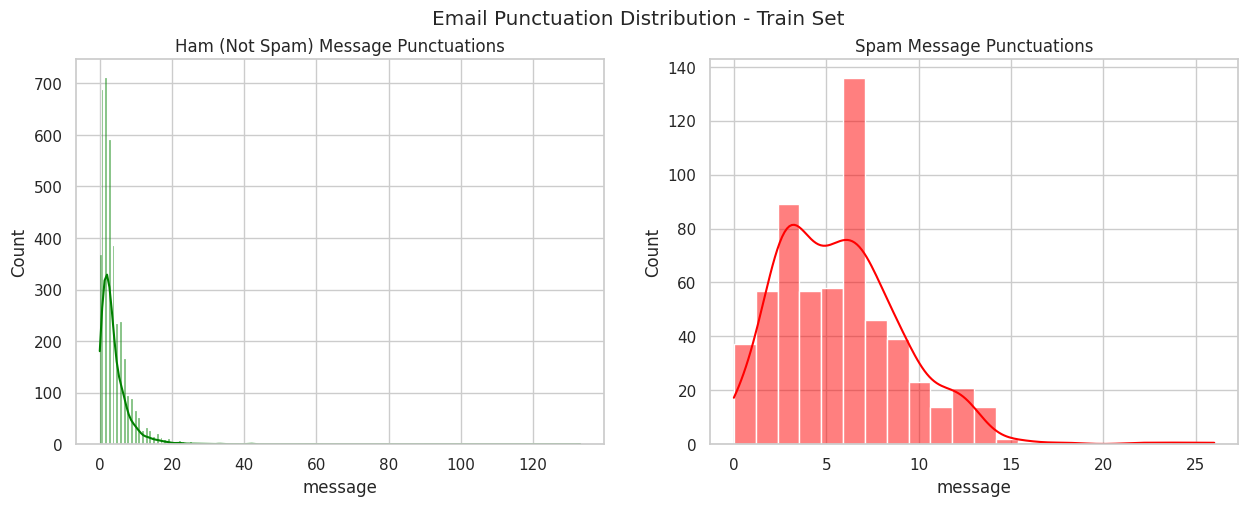

In [ ]:
# 📊 Count of punctuations in ham and spam messages

# Function for punctuation count
def count_punctuations(text):
    return len([c for c in str(text) if c in string.punctuation])

# Apply to each class in train set
count_ham_punct = df_train[df_train['class'] == 'ham']['message'].apply(count_punctuations)
count_spam_punct = df_train[df_train['class'] == 'spam']['message'].apply(count_punctuations)

# Print sample stats
print("Ham Message Punctuation Summary:\n", count_ham_punct.describe(), "\n")
print("Spam Message Punctuation Summary:\n", count_spam_punct.describe(), "\n")

# Plot results using the same generic plotter
plot_count(count_spam_punct, count_ham_punct,
            "Spam Message Punctuations",
            "Ham (Not Spam) Message Punctuations",
            "Email Punctuation Distribution - Train Set")


Ham Message Stopword Summary:
 count    3859.000000
mean        5.630215
std         5.583972
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        92.000000
Name: clean_text, dtype: float64 

Spam Message Stopword Summary:
 count    598.000000
mean       6.448161
std        3.205390
min        0.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       18.000000
Name: clean_text, dtype: float64 



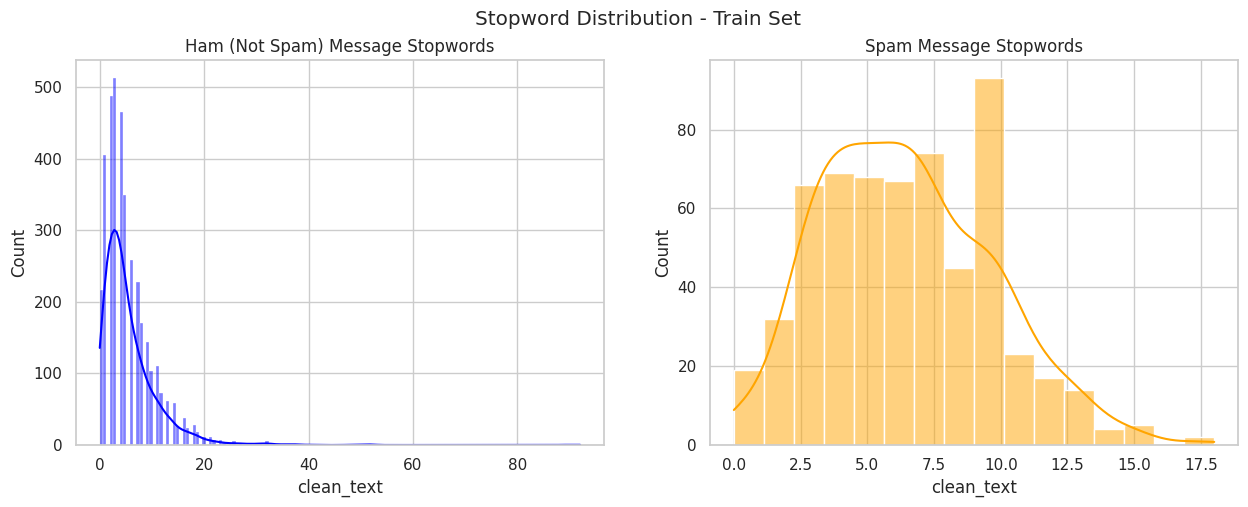

In [ ]:
# 📊 Analyse Stopwords in Ham and Spam Messages

def plot_count_1(count_spam, count_ham, title_spam, title_ham, subtitle):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(count_ham, ax=ax1, color='blue', kde=True)
    ax1.set_title(title_ham)
    sns.histplot(count_spam, ax=ax2, color='orange', kde=True)
    ax2.set_title(title_spam)
    fig.suptitle(subtitle)
    plt.show()

# 🔹 Define stopwords
stops = set(stopwords.words('english'))

# 🔹 Count how many stopwords appear in each message
def count_stopwords(text):
    words = str(text).split()
    return sum(1 for w in words if w.lower() in stops)

# 🔹 Apply to ham and spam in train dataset
count_ham_stops = df_train[df_train['class'] == 'ham']['clean_text'].apply(count_stopwords)
count_spam_stops = df_train[df_train['class'] == 'spam']['clean_text'].apply(count_stopwords)

# 🔹 Print summaries
print("Ham Message Stopword Summary:\n", count_ham_stops.describe(), "\n")
print("Spam Message Stopword Summary:\n", count_spam_stops.describe(), "\n")

# 🔹 Plot results
plot_count_1(count_spam_stops, count_ham_stops,
             "Spam Message Stopwords",
             "Ham (Not Spam) Message Stopwords",
             "Stopword Distribution - Train Set")


Ham Message URL Count Summary:
 count    3859.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: message, dtype: float64 

Spam Message URL Count Summary:
 count    598.000000
mean       0.033445
std        0.179946
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: message, dtype: float64 



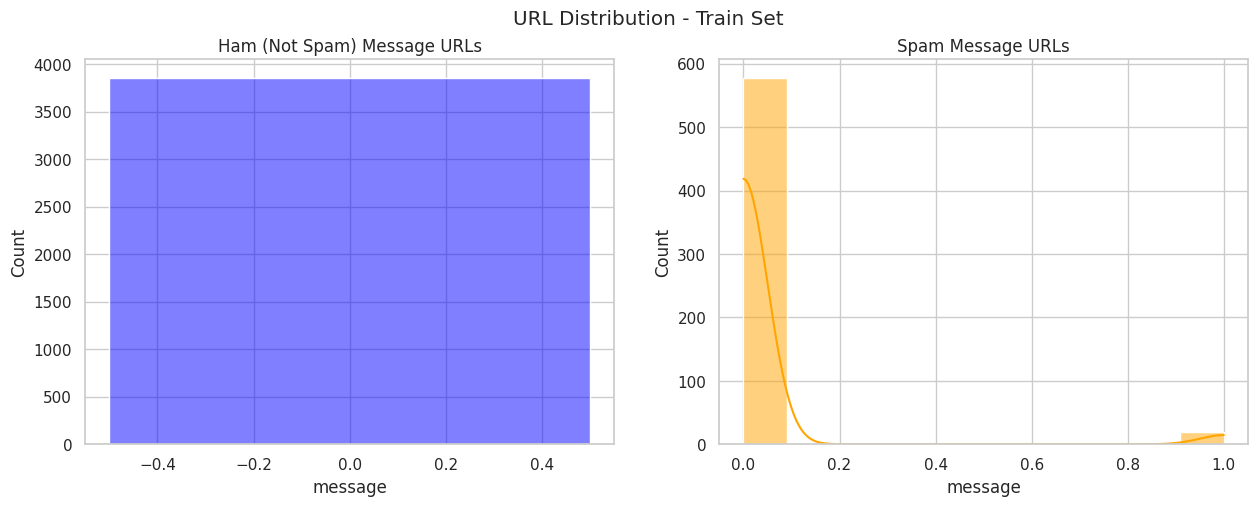

In [ ]:
# 📊 Analyse the number of URLs in ham and spam messages

# Function to count URLs in text
def count_urls(text):
    words = str(text).lower().split()
    return len([w for w in words if 'http' in w or 'https' in w])

# Apply to each class in the train set
count_ham_urls = df_train[df_train['class'] == 'ham']['message'].apply(count_urls)
count_spam_urls = df_train[df_train['class'] == 'spam']['message'].apply(count_urls)

# Print summary statistics
print("Ham Message URL Count Summary:\n", count_ham_urls.describe(), "\n")
print("Spam Message URL Count Summary:\n", count_spam_urls.describe(), "\n")

# Plot results using your Seaborn plotting function
plot_count_1(count_spam_urls, count_ham_urls,
             "Spam Message URLs",
             "Ham (Not Spam) Message URLs",
             "URL Distribution - Train Set")


/tmp/ipython-input-1476271776.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, palette='Reds_r')


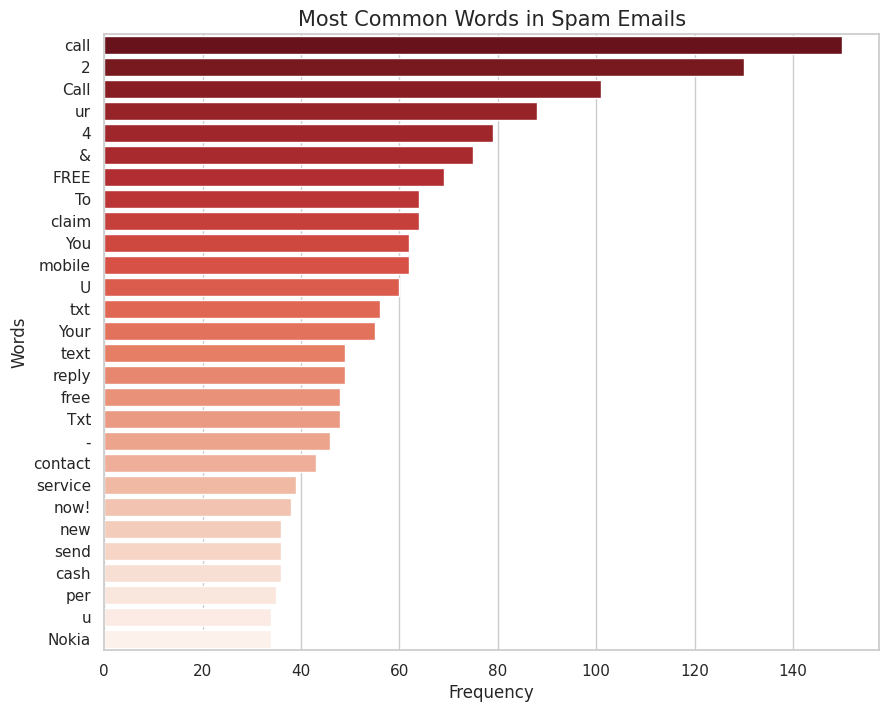

/tmp/ipython-input-1476271776.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, palette='Greens_r')


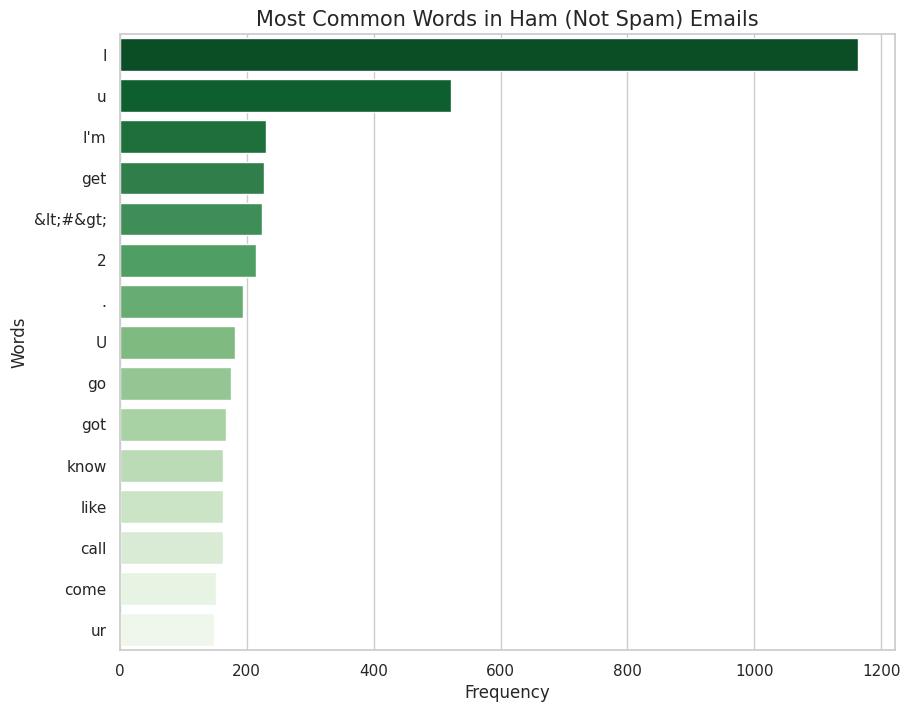

In [ ]:
# 📊 Simplified Counter Function for Ham or Spam Words

def create_corpus(label):
    corpus = []
    for message in df_train[df_train['class'] == label]['clean_text'].str.split():
        for word in message:
            corpus.append(word)
    return corpus

# Example: create corpus for Spam messages
corpus_spam = create_corpus('spam')
counter_spam = Counter(corpus_spam)
most_spam = counter_spam.most_common(50)

# Plot top 50 spam words (excluding stopwords)
x, y = [], []
for word, count in most_spam:
    if word not in stops:
        x.append(word)
        y.append(count)

plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x, palette='Reds_r')
plt.title("Most Common Words in Spam Emails", fontsize=15)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

# 🟩 (Optional) Repeat for Ham messages
corpus_ham = create_corpus('ham')
counter_ham = Counter(corpus_ham)
most_ham = counter_ham.most_common(50)

x, y = [], []
for word, count in most_ham:
    if word not in stops:
        x.append(word)
        y.append(count)

plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x, palette='Greens_r')
plt.title("Most Common Words in Ham (Not Spam) Emails", fontsize=15)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


**Preprocessing**

In [ ]:

def replace_strings(text):
    # remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text.lower()

def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def text_to_word_list(text):
    return text.split()

def joining(words):
    return ' '.join(words)

def preprocessing(text):
    text = replace_strings(text)
    text = remove_punctuations(text)
    return text


In [ ]:
X_train = X_train.apply(preprocessing)
X_val   = X_val.apply(preprocessing)
X_test  = X_test.apply(preprocessing)

**Stopwords Removal**

In [ ]:
# Clean version for English stopword removal
def stopwordRemoval(text):
    # Ensure input is string
    text = str(text)

    # Split into individual words
    words = text.split()

    # Remove English stopwords (using your 'stops' set)
    filtered_words = [word for word in words if word.lower() not in stops]

    # Join back into sentence
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text


In [ ]:
# Apply stopword removal to all splits (Train, Validation, Test)
X_train = X_train.apply(stopwordRemoval)
X_val   = X_val.apply(stopwordRemoval)
X_test  = X_test.apply(stopwordRemoval)

**Stemming**

In [ ]:
from nltk.stem import PorterStemmer

# Initialize English stemmer once
stemmer = PorterStemmer()

# Function to stem English words
def stem_text(text):
    text = str(text)
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)


In [ ]:
# Apply to all datasets
X_train = X_train.apply(stem_text)
X_val   = X_val.apply(stem_text)
X_test  = X_test.apply(stem_text)


**N-gram**

In [ ]:

# Function to generate n-grams (default: bigrams)
def generate_ngrams(text, n=2):
    text = str(text)
    tokens = text.split()
    return [' '.join(gram) for gram in ngrams(tokens, n)]


In [ ]:
# Apply bigram generation to all dataset splits
X_train = X_train.apply(lambda x: ' '.join(generate_ngrams(x, n=2)))
X_val   = X_val.apply(lambda x: ' '.join(generate_ngrams(x, n=2)))
X_test  = X_test.apply(lambda x: ' '.join(generate_ngrams(x, n=2)))


**Tokenization and Padding Sequence**

In [ ]:

# Define tokenizer settings
MAX_VOCAB = 20000
MAX_LEN = 150

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val   = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test  = pad_sequences(X_test_seq, maxlen=MAX_LEN)


/tmp/ipython-input-1420662742.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df_train, ax=axes[0], palette='crest')
/tmp/ipython-input-1420662742.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df_val, ax=axes[1], palette='crest')
/tmp/ipython-input-1420662742.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df_test, ax=axes[2], palette='crest')


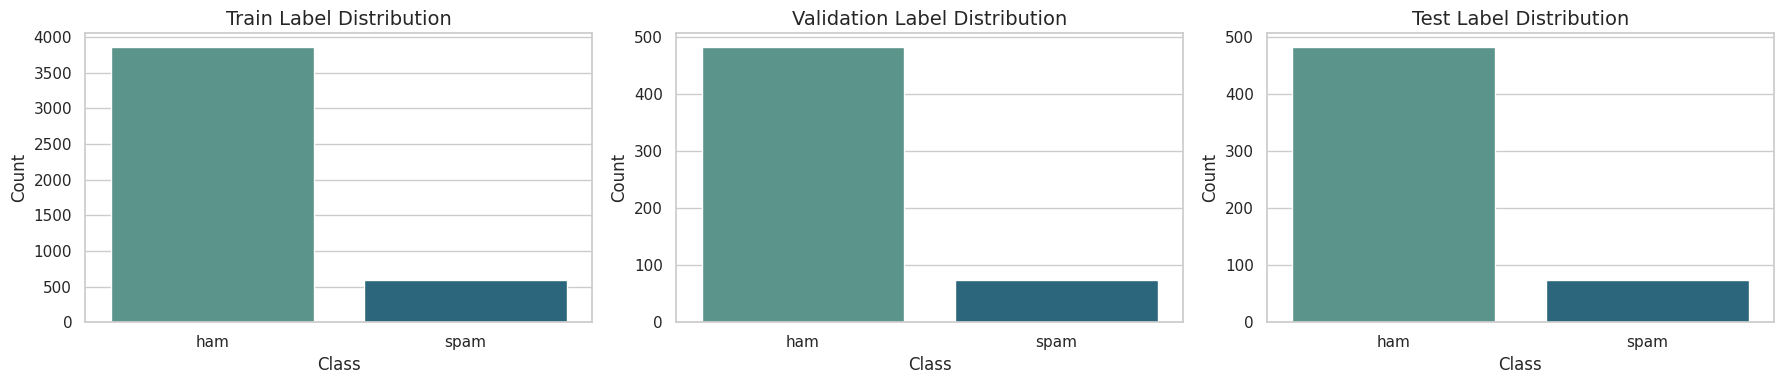

In [ ]:

# Global style
sns.set(style="whitegrid", rc={'figure.figsize': (18, 4)})

# Create subplots for Train, Validation, and Test
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Train set
sns.countplot(x='class', data=df_train, ax=axes[0], palette='crest')
axes[0].set_title('Train Label Distribution', fontsize=14)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Validation set
sns.countplot(x='class', data=df_val, ax=axes[1], palette='crest')
axes[1].set_title('Validation Label Distribution', fontsize=14)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

# Test set
sns.countplot(x='class', data=df_test, ax=axes[2], palette='crest')
axes[2].set_title('Test Label Distribution', fontsize=14)
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


**RNN Model**

In [ ]:

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

rnn_model = models.Sequential([
    layers.Embedding(vocab_size, 128),
    layers.SimpleRNN(64, dropout=0.3, recurrent_dropout=0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
rnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

bestpoint = callbacks.ModelCheckpoint(
    filepath='best_rnn.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
rnn_history = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[es, bestpoint],
    verbose=2
)


Epoch 1/20

Epoch 1: val_loss improved from inf to 0.35468, saving model to best_rnn.weights.h5
140/140 - 20s - 144ms/step - binary_accuracy: 0.8266 - loss: 0.4703 - val_binary_accuracy: 0.8671 - val_loss: 0.3547
Epoch 2/20

Epoch 2: val_loss improved from 0.35468 to 0.23167, saving model to best_rnn.weights.h5
140/140 - 9s - 64ms/step - binary_accuracy: 0.8661 - loss: 0.3516 - val_binary_accuracy: 0.8797 - val_loss: 0.2317
Epoch 3/20

Epoch 3: val_loss improved from 0.23167 to 0.13374, saving model to best_rnn.weights.h5
140/140 - 8s - 56ms/step - binary_accuracy: 0.9008 - loss: 0.2340 - val_binary_accuracy: 0.9623 - val_loss: 0.1337
Epoch 4/20

Epoch 4: val_loss improved from 0.13374 to 0.11085, saving model to best_rnn.weights.h5
140/140 - 11s - 81ms/step - binary_accuracy: 0.9610 - loss: 0.1120 - val_binary_accuracy: 0.9659 - val_loss: 0.1109
Epoch 5/20

Epoch 5: val_loss did not improve from 0.11085
140/140 - 9s - 63ms/step - binary_accuracy: 0.9780 - loss: 0.0674 - val_binary_acc

In [ ]:
url = "https://github.com/ayeshatofa/Email-Classification-using-RNN/raw/main/best_rnn.weights.h5"
gdown.download(url, "best_rnn.weights.h5", quiet=False)
rnn_model.load_weights("best_rnn.weights.h5")

Downloading...
From: https://github.com/ayeshatofa/Email-Classification-using-RNN/raw/main/best_rnn.weights.h5
To: /content/best_rnn.weights.h5
100%|██████████| 11.3M/11.3M [00:00<00:00, 106MB/s] 


In [ ]:
# Evaluate model on the test set
loss, acc = rnn_model.evaluate(X_test, y_test, verbose=0)

print(f"📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {acc:.4f}")


📊 Test Loss: 0.0967
✅ Test Accuracy: 0.9713


<Figure size 800x400 with 0 Axes>

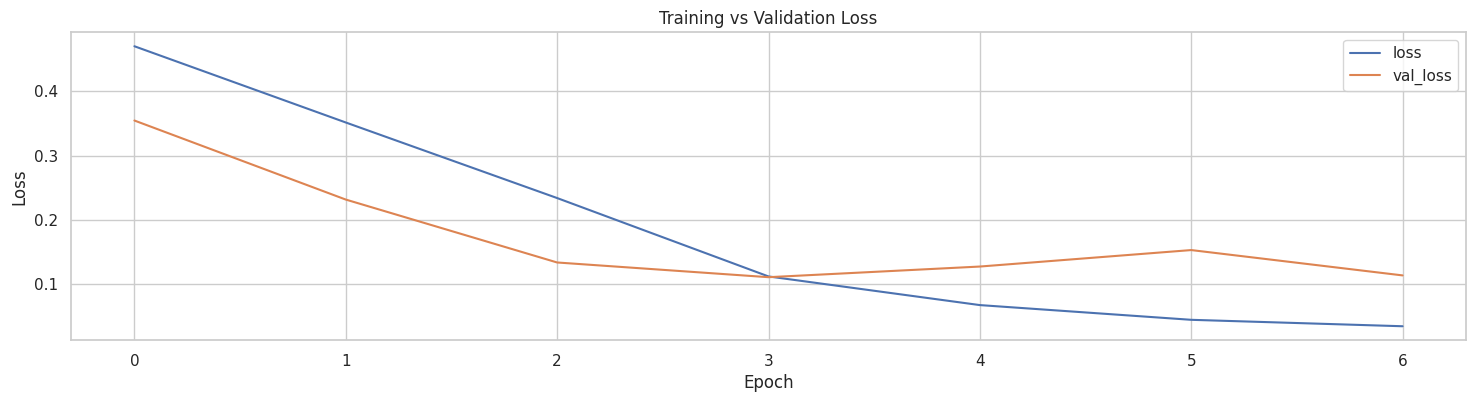

<Figure size 800x400 with 0 Axes>

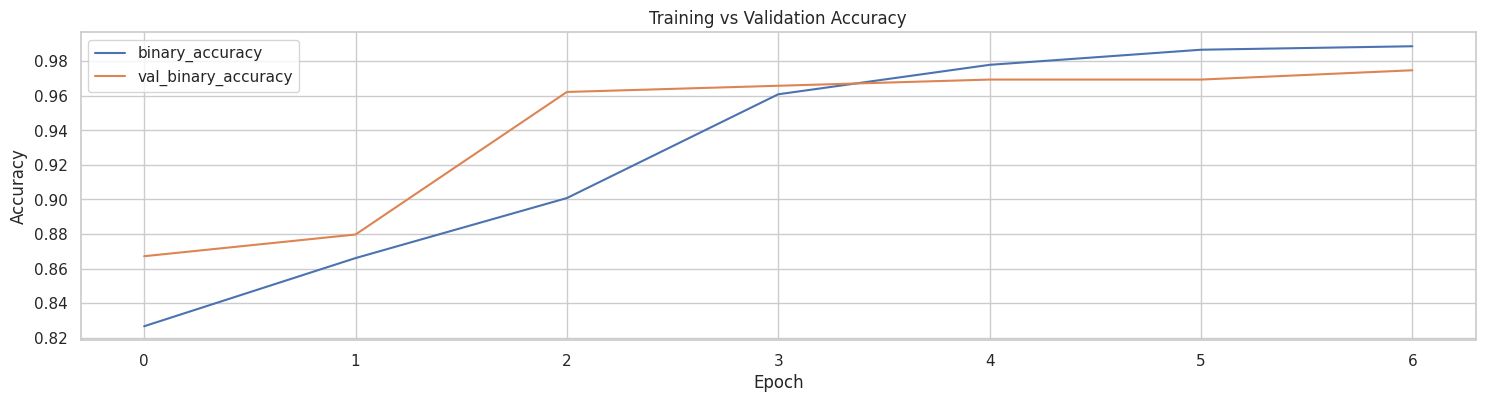

In [ ]:

# Convert training history to DataFrame
history_frame = pd.DataFrame(rnn_history.history)

# Plot Loss
plt.figure(figsize=(8, 4))
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 4))
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [ ]:

# Predict on test data
y_pred = rnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

# Compute metrics (weighted = handles class imbalance)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Display neatly formatted results
print(f"📊 Precision: {precision:.4f}")
print(f"📈 Recall:    {recall:.4f}")
print(f"🏆 F1 Score:  {f1:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
📊 Precision: 0.7492
📈 Recall:    0.8656
🏆 F1 Score:  0.8032


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# Classification report with readable class labels
print("📋 Classification Report:\n")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=label_encoder.classes_,
    digits=4
))


📋 Classification Report:

              precision    recall  f1-score   support

         ham     0.8656    1.0000    0.9280       483
        spam     0.0000    0.0000    0.0000        75

    accuracy                         0.8656       558
   macro avg     0.4328    0.5000    0.4640       558
weighted avg     0.7492    0.8656    0.8032       558



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


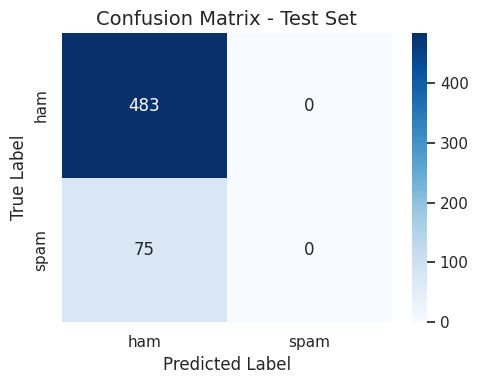

In [ ]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
labels = label_encoder.classes_  # ['ham', 'spam']

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Labels & title
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Example English sentence
custom_sentence ="Hi Sarah, I just wanted to let you know that I’ve completed the report you asked for, and I’ll send it over by this evening after making a few final edits to ensure all the data and charts are correctly formatted."


# 2️⃣ Apply full preprocessing pipeline
processed_sentence = preprocessing(custom_sentence)
processed_sentence = stopwordRemoval(processed_sentence)
processed_sentence = stem_text(processed_sentence)
processed_sentence = ' '.join(generate_ngrams(processed_sentence, n=2))

# 3️⃣ Convert to sequence and pad
seq = tokenizer.texts_to_sequences([processed_sentence])
padded_seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post')


In [ ]:
pred = rnn_model.predict(padded_seq)
pred_class = label_encoder.classes_[np.argmax(pred)]
print(f"Predicted label: {pred_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted label: ham


**LSTM**

In [ ]:

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

lstm_model = models.Sequential([
    layers.Embedding(vocab_size, 128),
    layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

bestpoint_lstm = callbacks.ModelCheckpoint(
    filepath='best_lstm.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[es, bestpoint_lstm],
    verbose=2
)


Epoch 1/20

Epoch 1: val_loss improved from inf to 0.05257, saving model to best_lstm.weights.h5
140/140 - 36s - 260ms/step - binary_accuracy: 0.9412 - loss: 0.1805 - val_binary_accuracy: 0.9874 - val_loss: 0.0526
Epoch 2/20

Epoch 2: val_loss did not improve from 0.05257
140/140 - 39s - 277ms/step - binary_accuracy: 0.9901 - loss: 0.0345 - val_binary_accuracy: 0.9856 - val_loss: 0.0569
Epoch 3/20

Epoch 3: val_loss did not improve from 0.05257
140/140 - 29s - 205ms/step - binary_accuracy: 0.9964 - loss: 0.0114 - val_binary_accuracy: 0.9838 - val_loss: 0.0661
Epoch 4/20

Epoch 4: val_loss did not improve from 0.05257
140/140 - 43s - 304ms/step - binary_accuracy: 0.9993 - loss: 0.0046 - val_binary_accuracy: 0.9838 - val_loss: 0.0718


In [ ]:
url = "https://github.com/ayeshatofa/Email-Classification-using-RNN/raw/main/best_lstm.weights.h5"
gdown.download(url, "best_lstm.weights.h5", quiet=False)
lstm_model.load_weights("best_lstm.weights.h5")

Downloading...
From: https://github.com/ayeshatofa/Email-Classification-using-RNN/raw/main/best_lstm.weights.h5
To: /content/best_lstm.weights.h5
100%|██████████| 11.7M/11.7M [00:00<00:00, 124MB/s]


In [ ]:
# Evaluate model on the test set
loss, acc = rnn_model.evaluate(X_test, y_test, verbose=0)

print(f"📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {acc:.4f}")


📊 Test Loss: 0.0967
✅ Test Accuracy: 0.9713


<Figure size 800x400 with 0 Axes>

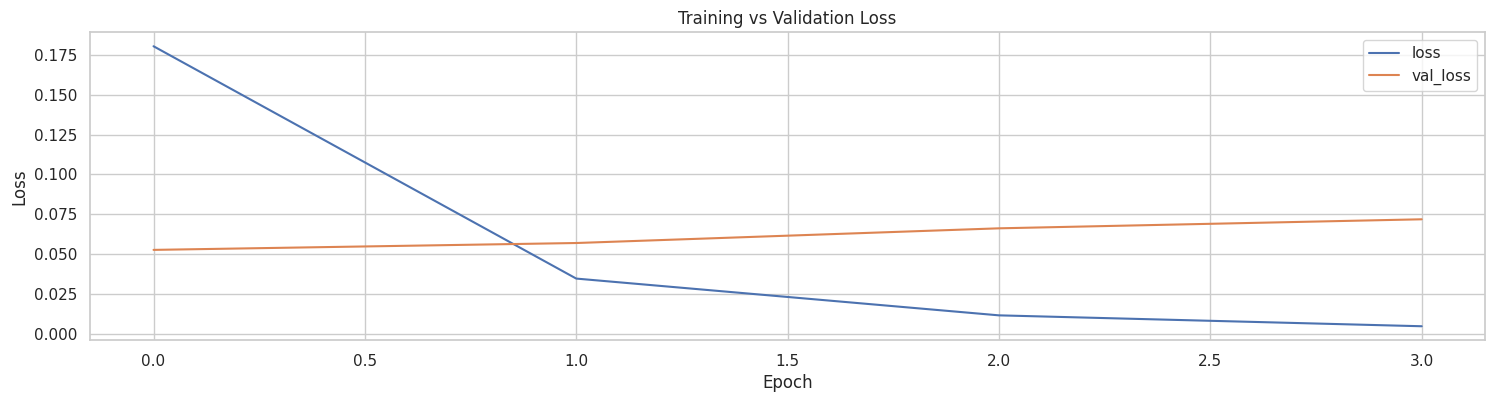

<Figure size 800x400 with 0 Axes>

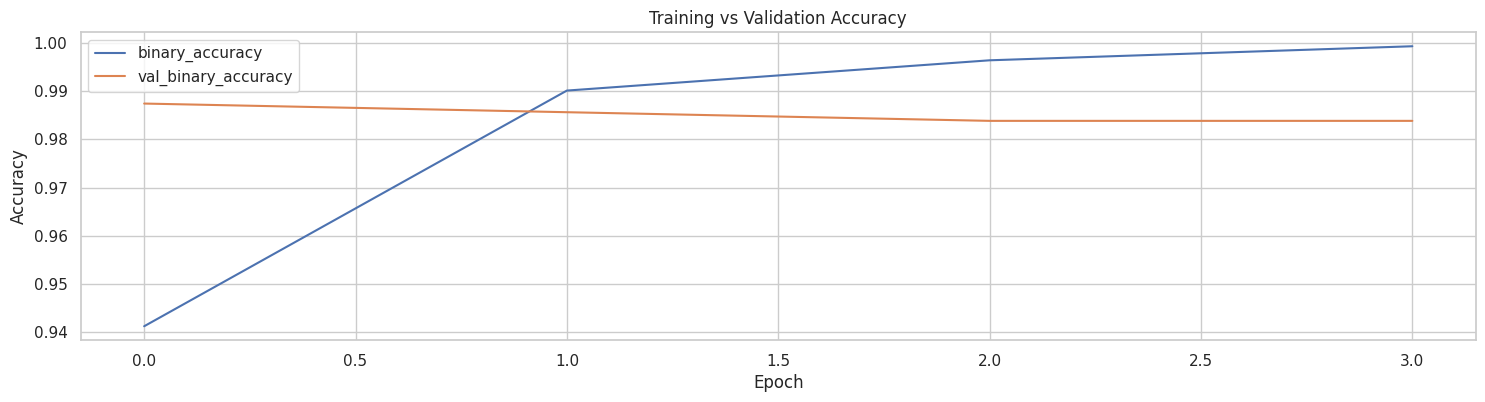

In [ ]:

# Convert training history to DataFrame
history_frame = pd.DataFrame(lstm_history.history)

# Plot Loss
plt.figure(figsize=(8, 4))
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 4))
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [ ]:

# Predict on test data
y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

# Compute metrics (weighted = handles class imbalance)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Display neatly formatted results
print(f"📊 Precision: {precision:.4f}")
print(f"📈 Recall:    {recall:.4f}")
print(f"🏆 F1 Score:  {f1:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
📊 Precision: 0.7492
📈 Recall:    0.8656
🏆 F1 Score:  0.8032


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# Classification report with readable class labels
print("📋 Classification Report:\n")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=label_encoder.classes_,
    digits=4
))


📋 Classification Report:

              precision    recall  f1-score   support

         ham     0.8656    1.0000    0.9280       483
        spam     0.0000    0.0000    0.0000        75

    accuracy                         0.8656       558
   macro avg     0.4328    0.5000    0.4640       558
weighted avg     0.7492    0.8656    0.8032       558



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


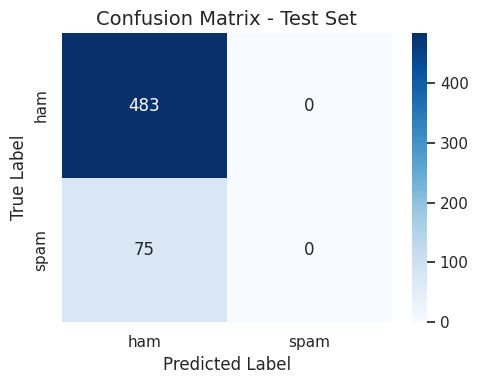

In [ ]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
labels = label_encoder.classes_  # ['ham', 'spam']

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Labels & title
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Example English sentence
custom_sentence = "Hi Sarah, I just wanted to let you know that I’ve completed the report you asked for, and I’ll send it over by this evening after making a few final edits to ensure all the data and charts are correctly formatted."


# 2️⃣ Apply full preprocessing pipeline
processed_sentence = preprocessing(custom_sentence)
processed_sentence = stopwordRemoval(processed_sentence)
processed_sentence = stem_text(processed_sentence)
processed_sentence = ' '.join(generate_ngrams(processed_sentence, n=2))

# 3️⃣ Convert to sequence and pad
seq = tokenizer.texts_to_sequences([processed_sentence])
padded_seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post')


In [ ]:
pred = lstm_model.predict(padded_seq)
pred_class = label_encoder.classes_[np.argmax(pred)]
print(f"Predicted label: {pred_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted label: ham
